## HOTEL BOOKING DEMAND

Business Problem : Cancel booking akan mengurangi jumlah pendapatan hotel, oleh karena itu hotel perlu mengambil beberapa keputusan agar jumlah cancel booking tidak besar atau bahkan tidak ada cancel booking dari calon pengunjung

## GOALS : PREDIKSI JUMLAH CANCEL BOOKING HOTEL

## Business Question :
    1. Berapa banyak calon customer yang melakukan cancel booking dilihat dari jenis deposit
    2. Berapa banyak calon customer yang melakukan cancel booking dilihat dari jenis customer
    3. Berapa banyak calon customer yang melakukan cancel booking dilihat dari jumlah perubahan calon pengunjung
    4. Berapa banyak calon customer yang melakukan cancel booking dilihat dari jumlah permintaan kusus dari calon pengunjung
    5. Berapa banyak calon customer yang melakukan cancel booking dilihat dari jumlah pemesanan yang sebelumnya dibatalkan calon pengunjung
    6. Berapa banyak calon customer yang melakukan cancel booking dilihat dari berapa lama waktu pemesanan sebelum dikonfirmasi ke calon pengunjung
    7. Berapa banyak calon customer yang melakukan cancel booking dilihat dari permintaan jumlah parkir mobil hotel
    8. Berapa banyak calon customer yang melakukan cancel booking dilihat dari tipe kamar yang dipesan calon pengunjung

In [1]:
!pip install category_encoders

In [2]:
!pip install xgboost


In [3]:
!pip install lightgbm

In [4]:
!pip install --upgrade scikit-learn 


In [5]:
pip install --upgrade scikit-learn imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [6]:
# Common Libraries used
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from itertools import product

# Feature Engineering
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.datasets import load_iris

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.experimental import enable_halving_search_cv


# For modelling
from lightgbm import LGBMClassifier


# For evaluation
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
#Membaca file dataset 'data_hotel_booking_demand'
df=pd.read_csv('data_hotel_booking_demand.csv')

#Menampilkan 5 baris pertama dari dataset
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [8]:
#Menampilkan 5 baris terkahir dari dataset
df.tail()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
83572,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


## Data Undersdtanding

# Data Dictionary
- country                     : Country of origin. Categories are represented in the ISO 3155–3:2013 format
- market_segment              : Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- previous_cancellations      : Number of previous bookings that were cancelled by the customer prior to the current booking
- booking_changes             : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of      check-in or   cancellation
- deposit_type                : Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
- days_in_waiting_list        : Number of days the booking was in the waiting list before it was confirmed to the customer
- customer_type               : Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
- reserved_room_type          : Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- required_car_parking_spaces : Number of car parking spaces required by the customer
- total_of_special_requests   : Number of special requests made by the customer (e.g. twin bed or high floor)
- is_canceled                 : Value indicating if the booking was canceled (1) or not (0)

In [9]:
#Menampilkan info dari data
print(f'Jumlah baris dan kolom dari dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom dari dataset df adalah (83573, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [10]:
#info dari data
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


## Data Cleaning

In [11]:
#Check data duplikat pada dataset
df.duplicated().sum()

73371

In [12]:
#persentase jumlah data duplikat
df.duplicated().sum()/df.shape[0]*100

87.79270817129934

Pada dataset ini, informasi identitas pribadi dihilangkan, sehingga tidak ada data unique (nama/ID).
Jika dilihat, jumlah duplicate data sangat besar yaitu sekitar 87,8%, sehingga untuk handling duplicate data ini akan dibuat kolom gabungan.
Beberapa kolom akan digabungkan melalui code berikut.

In [13]:
#Convert tipe data int menjadi str
df['convert_previous_cancellations']=df['previous_cancellations'].astype(str)
df['convert_booking_changes']=df['booking_changes'].astype(str)
df['convert_days_in_waiting_list']=df['days_in_waiting_list'].astype(str)

In [14]:
# membuat kolom baru (Combine_0) dengan menggabungkan kolom 'convert_country' dan 'convert_days_in_waiting_list' 
df['Combine_0']=df['country'] + '-' + df['convert_days_in_waiting_list']

In [15]:
df.duplicated().sum()

73371

Data duplikat belum ada perubahan, sehingga dilakukan penggabungan kolom berikut

In [16]:
Val_1 = df['Combine_0'].unique()
Val_2 = df['convert_booking_changes'].unique()
Val_3 = df['convert_previous_cancellations'].unique()

kombinasi = list(product(Val_1, Val_2, Val_3))

df_combined = pd.DataFrame(kombinasi, columns=['Combine_0', 'convert_booking_changes','convert_previous_cancellations'])

df['gabungan'] = df_combined['Combine_0'].astype(str) + '-' + df_combined['convert_booking_changes'].astype(str)+ '-' +df_combined['convert_previous_cancellations'].astype(str)


In [17]:
df.duplicated().sum()

0

Jumlah duplicate data sudah tidak ada, sehingga bisa dilanjutkan ke dalam proses mencari missing value

In [18]:
df.isna().sum()

country                           351
market_segment                      0
previous_cancellations              0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
reserved_room_type                  0
required_car_parking_spaces         0
total_of_special_requests           0
is_canceled                         0
convert_previous_cancellations      0
convert_booking_changes             0
convert_days_in_waiting_list        0
Combine_0                         351
gabungan                            0
dtype: int64

Terdapat missing value pada kolom country sebanyak 351, dimana jumlah ini sangat sedikit karena jika dilihat dalam persen akan seperti ini

In [19]:
df.isna().sum()/df.shape[0]*100

country                           0.419992
market_segment                    0.000000
previous_cancellations            0.000000
booking_changes                   0.000000
deposit_type                      0.000000
days_in_waiting_list              0.000000
customer_type                     0.000000
reserved_room_type                0.000000
required_car_parking_spaces       0.000000
total_of_special_requests         0.000000
is_canceled                       0.000000
convert_previous_cancellations    0.000000
convert_booking_changes           0.000000
convert_days_in_waiting_list      0.000000
Combine_0                         0.419992
gabungan                          0.000000
dtype: float64

persentase missing value pada kolom country hanya sekitar 0,42% dan jumlah ini sangat kecil sehingga missing value pada kolom country dapat dihapus

In [20]:
#Menghapus missing value
df.dropna(axis=0, inplace=True)
df.isna().sum()

country                           0
market_segment                    0
previous_cancellations            0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
reserved_room_type                0
required_car_parking_spaces       0
total_of_special_requests         0
is_canceled                       0
convert_previous_cancellations    0
convert_booking_changes           0
convert_days_in_waiting_list      0
Combine_0                         0
gabungan                          0
dtype: int64

Setelah dihapus, jumlah missing value di setiap kolom sudah tidak ada dan bisa dilanjut dengan melihat outliers data pada tiap kolom numerik

In [21]:
#Pengecekan Outliers
def cek_outliers(df, col):
    Q1 = df[col].describe()['25%']
    Q3 = df[col].describe()['75%']
    IQR = Q3-Q1
    upper_fence = Q3 + (1.5 * IQR)
    lower_fence = Q1 - (1.5 * IQR)
    df_outliers= df[(df[col] < lower_fence) | (df[col] > upper_fence)]
    if len(df_outliers) ==0:
        return "No Outliers"
    else:
        return df_outliers

In [22]:
cek_outliers(df, 'previous_cancellations')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list,Combine_0,gabungan
9,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1,1,0,0,PRT-0,IRL-0-0-26
12,PRT,Groups,1,0,Non Refund,0,Transient,A,0,0,1,1,0,0,PRT-0,IRL-0-0-19
32,PRT,Offline TA/TO,1,0,No Deposit,0,Transient,A,0,0,1,1,0,0,PRT-0,IRL-0-2-25
52,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1,1,0,0,PRT-0,IRL-0-5-13
72,ESP,Groups,1,0,Non Refund,0,Transient,A,0,0,1,1,0,0,ESP-0,IRL-0-3-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83465,PRT,Direct,1,0,No Deposit,0,Transient,E,1,4,0,1,0,0,PRT-0,NLD-5-16-11
83475,PRT,Offline TA/TO,1,0,Non Refund,0,Transient,A,0,0,1,1,0,0,PRT-0,NLD-5-20-0
83494,PRT,Online TA,1,0,No Deposit,0,Contract,D,0,1,1,1,0,0,PRT-0,NLD-5-15-3
83524,PRT,Offline TA/TO,1,0,Non Refund,46,Transient,A,0,0,1,1,0,46,PRT-46,ESP-83-1-3


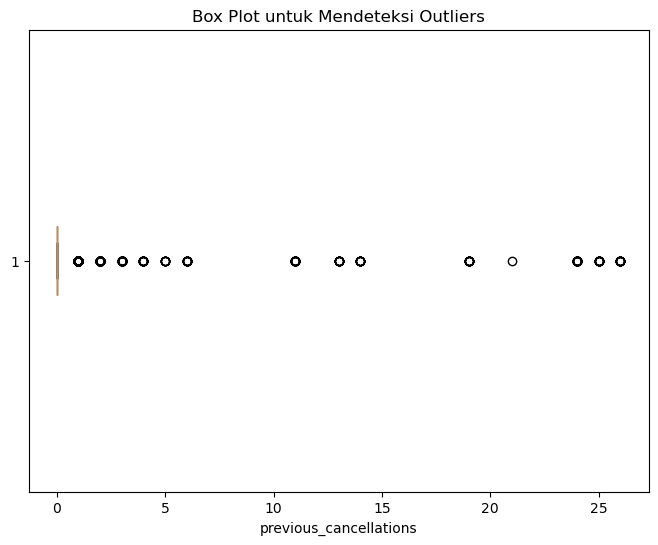

In [23]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['previous_cancellations'], vert=False, patch_artist=True)
plt.title('Box Plot untuk Mendeteksi Outliers')
plt.xlabel('previous_cancellations')
plt.show()

In [24]:
value_counts = df['previous_cancellations'].value_counts()

print("Frekuensi setiap nilai unik:")
print(value_counts)

Frekuensi setiap nilai unik:
previous_cancellations
0     78732
1      4186
2        84
3        46
24       33
11       28
6        19
4        19
26       18
25       17
19       12
13       10
14       10
5         7
21        1
Name: count, dtype: int64


In [25]:
cek_outliers(df, 'booking_changes')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list,Combine_0,gabungan
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,0,1,0,PRT-0,IRL-0-0-25
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,0,2,0,PRT-0,IRL-0-0-3
5,ESP,Direct,0,1,No Deposit,0,Transient-Party,A,0,1,0,0,1,0,ESP-0,IRL-0-0-11
10,CN,Groups,0,1,No Deposit,0,Transient-Party,A,0,1,0,0,1,0,CN-0,IRL-0-0-14
16,BRA,Offline TA/TO,0,1,No Deposit,0,Transient-Party,A,0,1,0,0,1,0,BRA-0,IRL-0-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83545,TUR,Online TA,0,1,No Deposit,0,Transient,A,0,0,0,0,1,0,TUR-0,ESP-83-2-14
83553,PRT,Groups,0,1,No Deposit,0,Transient-Party,A,0,0,0,0,1,0,PRT-0,ESP-83-5-2
83557,ESP,Online TA,0,1,No Deposit,0,Transient,D,0,2,0,0,1,0,ESP-0,ESP-83-5-13
83561,GBR,Online TA,0,1,No Deposit,0,Transient,E,0,3,0,0,1,0,GBR-0,ESP-83-5-4


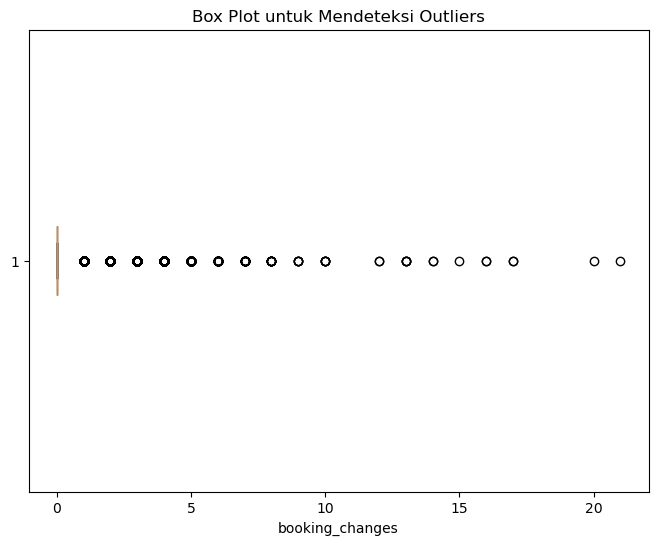

In [26]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['booking_changes'], vert=False, patch_artist=True)
plt.title('Box Plot untuk Mendeteksi Outliers')
plt.xlabel('booking_changes')
plt.show()

In [27]:
value_counts = df['booking_changes'].value_counts()

print("Frekuensi setiap nilai unik:")
print(value_counts)

Frekuensi setiap nilai unik:
booking_changes
0     70576
1      8926
2      2638
3       637
4       259
5        90
6        39
7        23
8        10
10        5
9         4
13        4
17        2
12        2
14        2
16        2
21        1
20        1
15        1
Name: count, dtype: int64


In [28]:
cek_outliers(df, 'days_in_waiting_list')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list,Combine_0,gabungan
14,PRT,Offline TA/TO,0,0,Non Refund,3,Transient,A,0,0,1,0,0,3,PRT-3,IRL-0-0-21
23,PRT,Offline TA/TO,0,0,Non Refund,39,Transient,A,0,0,1,0,0,39,PRT-39,IRL-0-1-6
64,PRT,Groups,0,2,No Deposit,87,Transient-Party,A,0,0,0,0,2,87,PRT-87,IRL-0-3-3
93,PRT,Offline TA/TO,0,0,Non Refund,77,Transient,A,0,0,1,0,0,77,PRT-77,IRL-0-6-2
110,PRT,Offline TA/TO,0,0,No Deposit,215,Transient-Party,A,0,0,1,0,0,215,PRT-215,IRL-0-7-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83503,ISR,Groups,0,0,No Deposit,58,Transient-Party,A,0,0,0,0,0,58,ISR-58,NLD-5-15-5
83523,PRT,Offline TA/TO,0,0,Non Refund,62,Transient,A,0,0,1,0,0,62,PRT-62,ESP-83-1-2
83524,PRT,Offline TA/TO,1,0,Non Refund,46,Transient,A,0,0,1,1,0,46,PRT-46,ESP-83-1-3
83535,ESP,Groups,0,0,No Deposit,47,Transient-Party,A,0,0,0,0,0,47,ESP-47,ESP-83-2-0


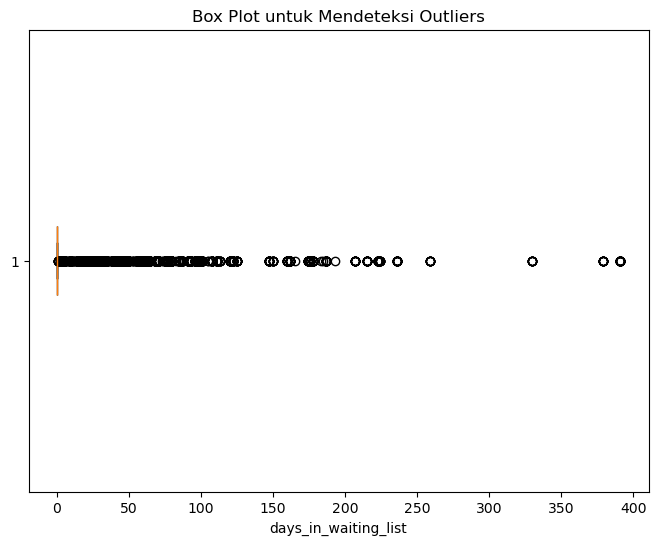

In [29]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['days_in_waiting_list'], vert=False, patch_artist=True)
plt.title('Box Plot untuk Mendeteksi Outliers')
plt.xlabel('days_in_waiting_list')
plt.show()

In [30]:
value_counts = df['days_in_waiting_list'].value_counts()

print("Frekuensi setiap nilai unik:")
print(value_counts)

Frekuensi setiap nilai unik:
days_in_waiting_list
0      80637
39       166
58       104
44        93
31        93
       ...  
74         1
121        1
36         1
64         1
185        1
Name: count, Length: 115, dtype: int64


In [31]:
cek_outliers(df, 'required_car_parking_spaces')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list,Combine_0,gabungan
15,LUX,Direct,0,0,No Deposit,0,Transient,D,1,0,0,0,0,0,LUX-0,IRL-0-1-0
43,PRT,Online TA,0,0,No Deposit,0,Transient,A,1,2,0,0,0,0,PRT-0,IRL-0-2-5
84,PRT,Corporate,0,0,No Deposit,0,Transient,A,1,2,0,0,0,0,PRT-0,IRL-0-4-26
90,PRT,Online TA,0,0,No Deposit,0,Transient,D,1,2,0,0,0,0,PRT-0,IRL-0-6-0
94,FRA,Direct,0,0,No Deposit,0,Transient,A,1,0,0,0,0,0,FRA-0,IRL-0-6-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83465,PRT,Direct,1,0,No Deposit,0,Transient,E,1,4,0,1,0,0,PRT-0,NLD-5-16-11
83466,IRL,Direct,0,0,No Deposit,0,Transient,D,1,1,0,0,0,0,IRL-0,NLD-5-16-24
83485,PRT,Offline TA/TO,0,0,No Deposit,0,Transient,A,1,0,0,0,0,0,PRT-0,NLD-5-20-14
83515,GBR,Direct,0,2,No Deposit,0,Transient-Party,A,1,1,0,0,2,0,GBR-0,ESP-83-0-14


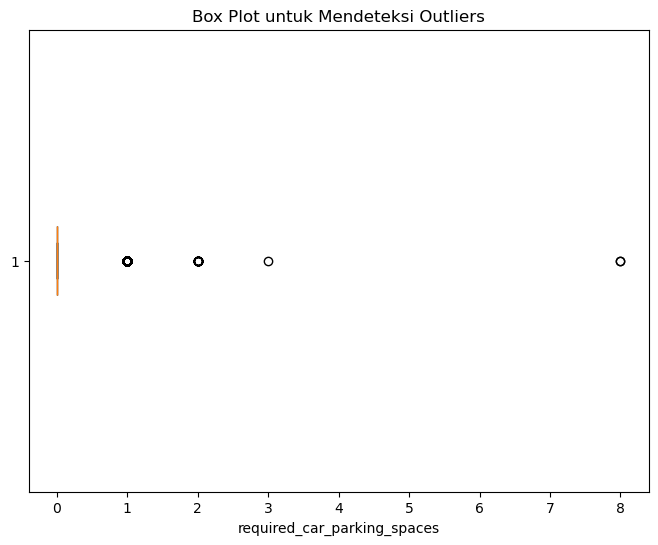

In [32]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['required_car_parking_spaces'], vert=False, patch_artist=True)
plt.title('Box Plot untuk Mendeteksi Outliers')
plt.xlabel('required_car_parking_spaces')
plt.show()

In [33]:
value_counts = df['required_car_parking_spaces'].value_counts()

print("Frekuensi setiap nilai unik:")
print(value_counts)

Frekuensi setiap nilai unik:
required_car_parking_spaces
0    78071
1     5126
2       22
8        2
3        1
Name: count, dtype: int64


In [34]:
cek_outliers(df, 'total_of_special_requests')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list,Combine_0,gabungan
101,CHN,Online TA,0,0,No Deposit,0,Transient,G,1,3,0,0,0,0,CHN-0,IRL-0-6-4
105,PRT,Online TA,0,1,No Deposit,0,Transient-Party,A,0,3,0,0,1,0,PRT-0,IRL-0-7-0
118,FRA,Online TA,0,1,No Deposit,0,Transient,E,1,3,0,0,1,0,FRA-0,IRL-0-7-5
211,GBR,Direct,0,0,No Deposit,0,Transient,A,0,3,0,0,0,0,GBR-0,IRL-0-14-1
234,CHN,Online TA,0,0,No Deposit,0,Transient-Party,A,0,3,0,0,0,0,CHN-0,IRL-0-21-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83404,ESP,Direct,0,0,No Deposit,0,Transient,E,1,3,0,0,0,0,ESP-0,NLD-5-13-3
83465,PRT,Direct,1,0,No Deposit,0,Transient,E,1,4,0,1,0,0,PRT-0,NLD-5-16-11
83561,GBR,Online TA,0,1,No Deposit,0,Transient,E,0,3,0,0,1,0,GBR-0,ESP-83-5-4
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1,0,0,0,PRT-0,ESP-83-3-2


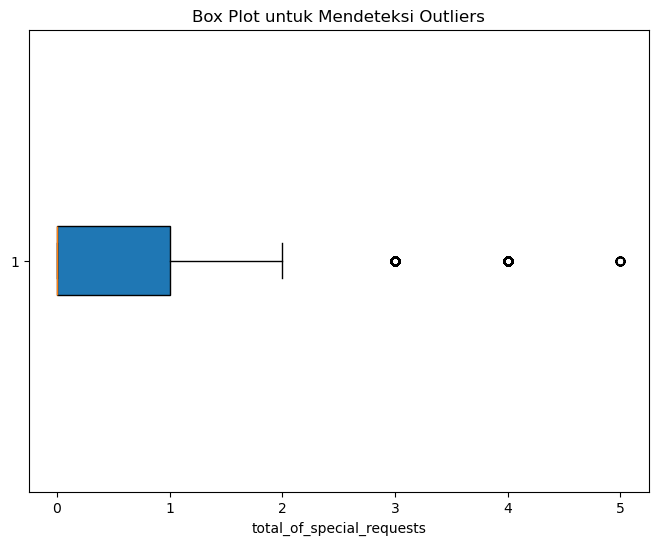

In [35]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['total_of_special_requests'], vert=False, patch_artist=True)
plt.title('Box Plot untuk Mendeteksi Outliers')
plt.xlabel('total_of_special_requests')
plt.show()

In [36]:
value_counts = df['total_of_special_requests'].value_counts()

print("Frekuensi setiap nilai unik:")
print(value_counts)

Frekuensi setiap nilai unik:
total_of_special_requests
0    48951
1    23141
2     9089
3     1776
4      235
5       30
Name: count, dtype: int64


In [37]:
cek_outliers(df, 'is_canceled')

'No Outliers'

## Data Analysis

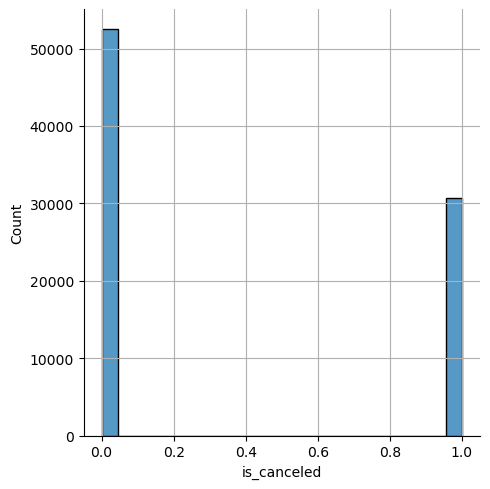

In [38]:
sns.displot(x = df['is_canceled'])
plt.grid(True)
plt.show()

In [39]:
df['is_canceled'].value_counts()

is_canceled
0    52490
1    30732
Name: count, dtype: int64

Dari data terlihat jumlah calon pengunjung yang melakukan cancel booking sebanyak 30732 dan yang tidak melakukan cancel booking sebanyak 52490. Perbandingan data ini tidak terlalu signifikan, sehingga tidak perlu dilakukan balancing

In [40]:
ct=pd.crosstab(index=df['customer_type'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
ct

is_canceled,0,1
customer_type,,
Transient,37083,25331
Transient-Party,13031,4476
Contract,1997,885
Group,379,40


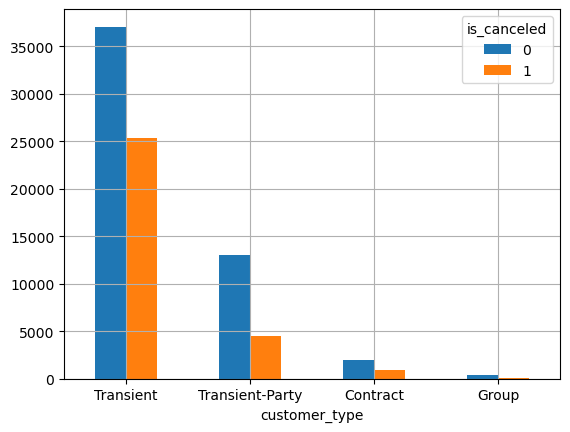

In [41]:
ct.plot(kind='bar')
plt.xticks(rotation=360)
plt.grid()
plt.show()

insight : tipe customer Transient paling banyak melakukan cancel booking dan tipe customer Group yang paling sedikit melakukan cancel booking

In [42]:
dt=pd.crosstab(index=df['deposit_type'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
dt

is_canceled,0,1
deposit_type,,
No Deposit,52340,20672
Non Refund,63,10037
Refundable,87,23


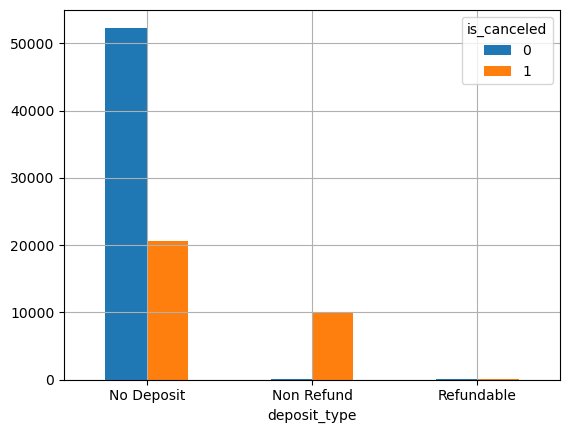

In [43]:
dt.plot(kind='bar')
plt.xticks(rotation=360)
plt.grid()
plt.show()

insight : calon pengunjung yang memilih tanpa deposit paling banyak melakukan cancel booking sebanyak 20672 dan calon pengunjung dengan tipe deposit refundable paling sedikit melakuan cancel booking

In [44]:
ms=pd.crosstab(index=df['market_segment'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
ms

is_canceled,0,1
market_segment,,
Online TA,24975,14433
Groups,5306,8412
Offline TA/TO,11214,5766
Direct,7437,1339
Corporate,2990,678
Complementary,438,68
Aviation,130,35
Undefined,0,1


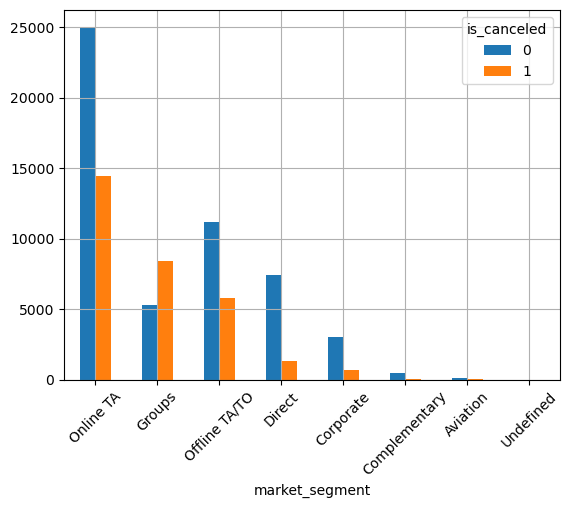

In [45]:
ms.plot(kind='bar')
plt.xticks(rotation=45)
plt.grid()
plt.show()

insight : market segment Online TA paling banyak melakukan cancel booking sebanyak 14433 dan market segment undefined paling sedikit melakukan cancel booking sebanyak 1

In [46]:
pc=pd.crosstab(index=df['previous_cancellations'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
pc

is_canceled,0,1
previous_cancellations,,
0,52112,26620
1,232,3954
24,0,33
2,58,26
26,0,18
25,0,17
3,30,16
19,0,12
14,0,10


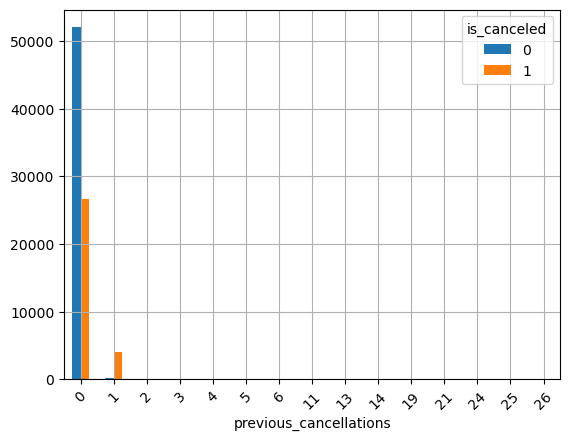

In [47]:
pc_0=pd.crosstab(index=df['previous_cancellations'], columns=df['is_canceled'])
pc_0.plot(kind='bar')
plt.xticks(rotation=45)
plt.grid()
plt.show()

insight : cancel booking paling banyak dilakukan oleh calon pengunjung yang belum pernah melakukan pembatalan sebelumnya

In [48]:
bc=pd.crosstab(index=df['booking_changes'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
bc

is_canceled,0,1
booking_changes,,
0,41817,28759
1,7643,1283
2,2116,522
3,545,92
4,216,43
5,76,14
6,27,12
8,6,4
7,22,1


insigth : calon pengunjung yang 

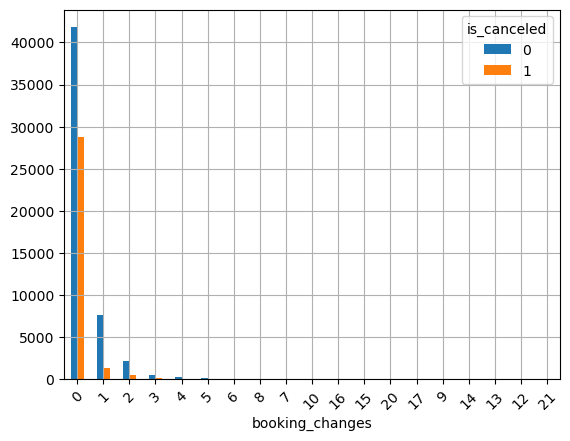

In [49]:
bc.plot(kind='bar')
plt.xticks(rotation=45)
plt.grid()
plt.show()

insight : calon pengunjung yang tidak melakukan perubahan yang paling banyak melakukan cancel booking

In [50]:
diwl=pd.crosstab(index=df['days_in_waiting_list'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
diwl

is_canceled,0,1
days_in_waiting_list,,
0,51566,29071
39,0,166
31,1,92
44,20,73
46,1,65
...,...,...
58,104,0
65,23,0
36,1,0


In [51]:
rrt=pd.crosstab(index=df['reserved_room_type'], columns=df['is_canceled']).sort_values(by=1, ascending=False)
rrt

is_canceled,0,1
reserved_room_type,,
A,36405,23356
D,9237,4268
E,3272,1349
F,1426,606
G,919,519
B,532,255
C,459,213
H,238,163
P,0,2


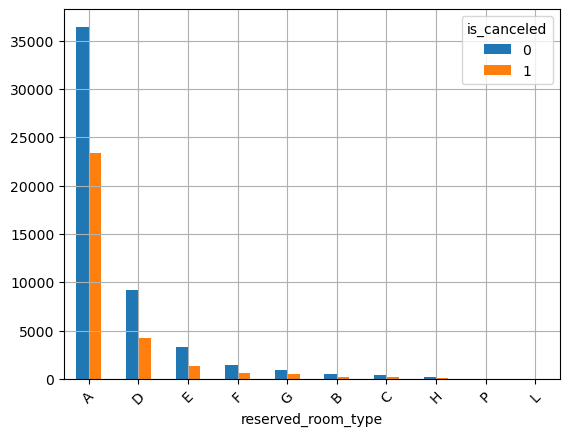

In [52]:
rrt.plot(kind='bar')
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Feature Encoding

In [53]:
# all object columns
c = df.select_dtypes('object').columns
df[c] = df[c].astype('category')

# change is_canceled data type
df['is_canceled'] = df['is_canceled'].astype('category')

In [54]:

listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,category,0,0.0,162,"[MWI, PAN]"
1,market_segment,category,0,0.0,8,"[Aviation, Corporate]"
2,previous_cancellations,int64,0,0.0,15,"[19, 5]"
3,booking_changes,int64,0,0.0,19,"[0, 15]"
4,deposit_type,category,0,0.0,3,"[No Deposit, Refundable]"
5,days_in_waiting_list,int64,0,0.0,115,"[33, 22]"
6,customer_type,category,0,0.0,4,"[Contract, Group]"
7,reserved_room_type,category,0,0.0,10,"[C, B]"
8,required_car_parking_spaces,int64,0,0.0,5,"[2, 3]"
9,total_of_special_requests,int64,0,0.0,6,"[0, 4]"


In [97]:
#drop kolom Combine_0 dan gabungan karena itu hanya unique identifier.
for col in ['Combine_0', 'gabungan']:
    del df[col]
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,convert_previous_cancellations,convert_booking_changes,convert_days_in_waiting_list
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,0,0,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,0,1,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,0,0,0
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1,0,0,0
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0,0,0,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0,0,1,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,0,0,0


In [118]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['deposit_type','customer_type']),
    ('binary', ce.BinaryEncoder(), ['country','market_segment', 'reserved_room_type', 'convert_previous_cancellations','convert_booking_changes','convert_days_in_waiting_list' ])
], remainder='passthrough')

In [119]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [120]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=999)

In [121]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
testing.head()

,onehot__deposit_type_Non Refund,onehot__deposit_type_Refundable,onehot__customer_type_Group,onehot__customer_type_Transient,onehot__customer_type_Transient-Party,binary__country_0,binary__country_1,binary__country_2,binary__country_3,binary__country_4,...,binary__convert_days_in_waiting_list_2,binary__convert_days_in_waiting_list_3,binary__convert_days_in_waiting_list_4,binary__convert_days_in_waiting_list_5,binary__convert_days_in_waiting_list_6,remainder__previous_cancellations,remainder__booking_changes,remainder__days_in_waiting_list,remainder__required_car_parking_spaces,remainder__total_of_special_requests
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [122]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

In [123]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
result_df=pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)
result_df

[LightGBM] [Info] Number of positive: 17209, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 46604, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369260 -> initscore=-0.535392
[LightGBM] [Info] Start training from score -0.535392
[LightGBM] [Info] Number of positive: 17209, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 46604, number of used features: 39
[LightGBM] [Info] [b

,mean roc_auc,sdev
model,,
XGBoost,0.893906,0.002027
LightGBM,0.892817,0.002561
Random Forest,0.887003,0.003101
Decision Tree,0.875791,0.003484
KNN,0.847803,0.003801
Logistic Regression,0.847009,0.003472


In [124]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84     15747
           1       0.82      0.54      0.65      9220

    accuracy                           0.78     24967
   macro avg       0.80      0.73      0.75     24967
weighted avg       0.79      0.78      0.77     24967

KNN 
               precision    recall  f1-score   support

           0       0.80      0.87      0.84     15747
           1       0.75      0.63      0.68      9220

    accuracy                           0.78     24967
   macro avg       0.77      0.75      0.76     24967
weighted avg       0.78      0.78      0.78     24967

Decision Tree 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85     15747
           1       0.75      0.70      0.73      9220

    accuracy                           0.81     24967
   macro avg       0.79      0.78      0.79     24967
weighted avg       0.80      0

,roc_auc score
model,
XGBoost,0.892969
LightGBM,0.891959
Random Forest,0.889192
Decision Tree,0.880098
KNN,0.850979
Logistic Regression,0.848902


In [125]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [126]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [127]:
data = x_train
target = y_train

In [128]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
    #print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

[LightGBM] [Info] Number of positive: 19360, number of negative: 33069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 52429, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369261 -> initscore=-0.535387
[LightGBM] [Info] Start training from score -0.535387
[LightGBM] [Info] Number of positive: 33069, number of negative: 33069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 66138, number of used features: 40
[LightGBM] [Info] [b

In [129]:

listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.812947,0.808960,0.898519,0.896342,0.794527,0.788775,0.695351,0.676580,0.774970,0.777363
1,0.813329,0.816855,0.898750,0.895230,0.794822,0.800094,0.694628,0.713755,0.776309,0.773025
2,0.814358,0.815311,0.899067,0.895801,0.795830,0.797405,0.694747,0.701534,0.778685,0.776634
3,0.813977,0.816341,0.898605,0.895318,0.795229,0.797338,0.692423,0.690841,0.779237,0.785828
4,0.814530,0.811363,0.899582,0.893727,0.796304,0.794099,0.697846,0.706648,0.777164,0.764588
5,0.815049,0.805150,0.899760,0.883959,0.797052,0.784122,0.700377,0.667596,0.776810,0.773707
6,0.814114,0.808927,0.898710,0.890209,0.796024,0.789635,0.699086,0.685263,0.775423,0.771728
7,0.814743,0.811845,0.898666,0.894555,0.796747,0.792729,0.700274,0.688052,0.776162,0.776903
8,0.814686,0.813562,0.898726,0.891974,0.796489,0.796757,0.698208,0.712227,0.777299,0.766383
9,0.814648,0.812532,0.898831,0.896962,0.796665,0.794739,0.700377,0.701534,0.775877,0.770291


In [130]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.801128,0.804669,0.899106,0.896255,0.801119,0.793997,0.794551,0.781134,0.805142,0.715928
1,0.803970,0.796258,0.899795,0.895149,0.803964,0.787026,0.798301,0.796004,0.807457,0.696059
2,0.802453,0.801751,0.898792,0.895735,0.802447,0.792136,0.797176,0.794514,0.805679,0.705615
3,0.802090,0.798833,0.898708,0.895616,0.802089,0.789416,0.800865,0.795444,0.802831,0.700368
4,0.802967,0.797975,0.899498,0.893276,0.802957,0.788534,0.796117,0.794514,0.807175,0.699264
5,0.801113,0.792275,0.899390,0.883283,0.801105,0.781333,0.794762,0.769874,0.804986,0.698439
6,0.802307,0.796395,0.899832,0.889350,0.802297,0.785980,0.795216,0.779637,0.806656,0.701967
7,0.802292,0.799142,0.899638,0.894974,0.802286,0.789527,0.796607,0.792655,0.805769,0.701935
8,0.802746,0.796738,0.899128,0.891681,0.802735,0.787204,0.795216,0.792190,0.807375,0.698075
9,0.803094,0.803090,0.898608,0.896935,0.803086,0.793521,0.796849,0.795909,0.806927,0.707438


In [131]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])
     

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3674
           1       0.78      0.68      0.72      2152

    accuracy                           0.81      5826
   macro avg       0.80      0.78      0.79      5826
weighted avg       0.81      0.81      0.81      5826

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3674
           1       0.77      0.71      0.74      2152

    accuracy                           0.82      5826
   macro avg       0.81      0.80      0.80      5826
weighted avg       0.81      0.82      0.82      5826

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3675
           1       0.78      0.70      0.74      2151

    accuracy                           0.82      5826
   macro avg       0.81      0.79      0.80      5826
weighted avg       0.81      0.82      0.81      5826

              preci

In [132]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3674
           1       0.72      0.78      0.75      2152

    accuracy                           0.80      5826
   macro avg       0.79      0.80      0.79      5826
weighted avg       0.81      0.80      0.81      5826

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3674
           1       0.70      0.80      0.74      2152

    accuracy                           0.80      5826
   macro avg       0.78      0.80      0.79      5826
weighted avg       0.81      0.80      0.80      5826

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3675
           1       0.71      0.79      0.75      2151

    accuracy                           0.80      5826
   macro avg       0.79      0.80      0.79      5826
weighted avg       0.81      0.80      0.80      5826

              preci

In [133]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=999)
transformer = StandardScaler()

estimator=ImbPipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [134]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__n_estimators':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [999]
}]

In [135]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [136]:
halving_cv = HalvingGridSearchCV(
    estimator, param_grid=hyperparam_space, scoring='roc_auc_ovr', n_jobs=-1, min_resources='exhaust', factor=3
)

halving_cv.fit(x_train,y_train)
print(halving_cv.best_score_)
print(halving_cv.best_params_)

ValueError: 
All the 5120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'FRA'

--------------------------------------------------------------------------------
1024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'ESP'

--------------------------------------------------------------------------------
1024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'PRT'

--------------------------------------------------------------------------------
1024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'GBR'

--------------------------------------------------------------------------------
1024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\imman\anaconda3\Lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'DEU'
